In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn.functional as F
from datasets import Dataset
from transformers import AutoTokenizer, AutoModel
import accelerate
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from IPython.display import display

# --- 1. GPUの確認 ---
if torch.cuda.is_available():
    print(f"✅ GPU is available. Device: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("⚠️ GPU not found. Running on CPU.")
    device = torch.device("cpu")

✅ GPU is available. Device: NVIDIA RTX A6000


In [2]:
# --- 2. 設定 ---

# 最終版のクリーニング済みデータ
TRAINING_FILE = "data/processed/training_dataset_abstract_cleaned_v3.csv"
# TRAINING_FILE = "data/processed/training_dataset_hard_negatives_1to3.csv"

# ▼▼▼ 修正点: 事前学習済みモデルを使用 ▼▼▼
MODEL_CHECKPOINT = "allenai/scibert_scivocab_uncased"

# 推論（Embedding）時のバッチサイズ
# (GPUメモリが許す限り大きくすると高速になります)
INFERENCE_BATCH_SIZE = 256 
MAX_LENGTH = 512

print("Configuration set for Pre-trained Similarity Analysis.")

Configuration set for Pre-trained Similarity Analysis.


In [3]:
# --- 3. 事前学習済みモデルとトークナイザのロード ---

print(f"Loading tokenizer: {MODEL_CHECKPOINT}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

print(f"Loading PRE-TRAINED model: {MODEL_CHECKPOINT}")
# ▼▼▼ 修正点: AutoModelを使用 (分類ヘッドのない、生のBERT) ▼▼▼
model = AutoModel.from_pretrained(MODEL_CHECKPOINT).to(device)
model.eval() # 評価モードに設定
print("Model and tokenizer loaded successfully.")

Loading tokenizer: allenai/scibert_scivocab_uncased


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Loading PRE-TRAINED model: allenai/scibert_scivocab_uncased


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Model and tokenizer loaded successfully.


In [4]:
# --- 4. データセットの読み込み ---
print(f"Loading dataset: {TRAINING_FILE}")
df = pd.read_csv(TRAINING_FILE)
df = df.dropna(subset=['abstract_a', 'abstract_b', 'label'])
df['label'] = df['label'].astype(int)
print(f"Loaded {len(df)} pairs.")

# Hugging Face Datasets形式に変換
dataset = Dataset.from_pandas(df)

Loading dataset: data/processed/training_dataset_abstract_cleaned_v3.csv
Loaded 34624 pairs.


In [5]:
# --- 5. Embedding（ベクトル化）関数の定義 ---

def get_cls_embeddings(batch_texts):
    """
    テキストのバッチを受け取り、
    事前学習済みSciBERTのCLSトークンベクトルを返す
    """
    # トークナイズ
    inputs = tokenizer(
        batch_texts, 
        padding="max_length", 
        truncation=True, 
        max_length=MAX_LENGTH, 
        return_tensors="pt"
    ).to(device)
    
    # 勾配計算を無効にして推論
    with torch.no_grad():
        outputs = model(**inputs)
    
    # CLSプーリング（実験計画書と一致）
    cls_embeddings = outputs.pooler_output
    
    # GPUからCPUに戻す
    return cls_embeddings.cpu().numpy()

print("Embedding function defined.")

Embedding function defined.


In [6]:
# --- 6. 全ペアのベクトル化と類似度計算 ---

print("Calculating embeddings for 'abstract_a'...")
vecs_a = dataset.map(
    lambda batch: {'vec_a': get_cls_embeddings(batch['abstract_a'])},
    batched=True,
    batch_size=INFERENCE_BATCH_SIZE
)['vec_a']

print("Calculating embeddings for 'abstract_b'...")
vecs_b = dataset.map(
    lambda batch: {'vec_b': get_cls_embeddings(batch['abstract_b'])},
    batched=True,
    batch_size=INFERENCE_BATCH_SIZE
)['vec_b']

print("Calculating cosine similarity...")
# 高速な計算のため、Numpy配列からTorchテンソルに変換
vecs_a_tensor = torch.tensor(np.array(vecs_a))
vecs_b_tensor = torch.tensor(np.array(vecs_b))

# コサイン類似度を計算
cos_sim = F.cosine_similarity(vecs_a_tensor, vecs_b_tensor, dim=1)

# 元のDataFrameに類似度とラベルを追加
df_results = pd.DataFrame({
    'cosine_similarity': cos_sim.numpy(),
    'label': dataset['label']
})

print("Analysis complete.")
display(df_results.head())

Calculating embeddings for 'abstract_a'...


Map:   0%|          | 0/34624 [00:00<?, ? examples/s]

Calculating embeddings for 'abstract_b'...


Map:   0%|          | 0/34624 [00:00<?, ? examples/s]

Calculating cosine similarity...
Analysis complete.


,cosine_similarity,label
0,0.589860,1
1,0.674638,1
2,0.891160,1
3,0.508810,1
4,0.696796,1



--- Visualization 1: Positive vs. Negative Distribution ---


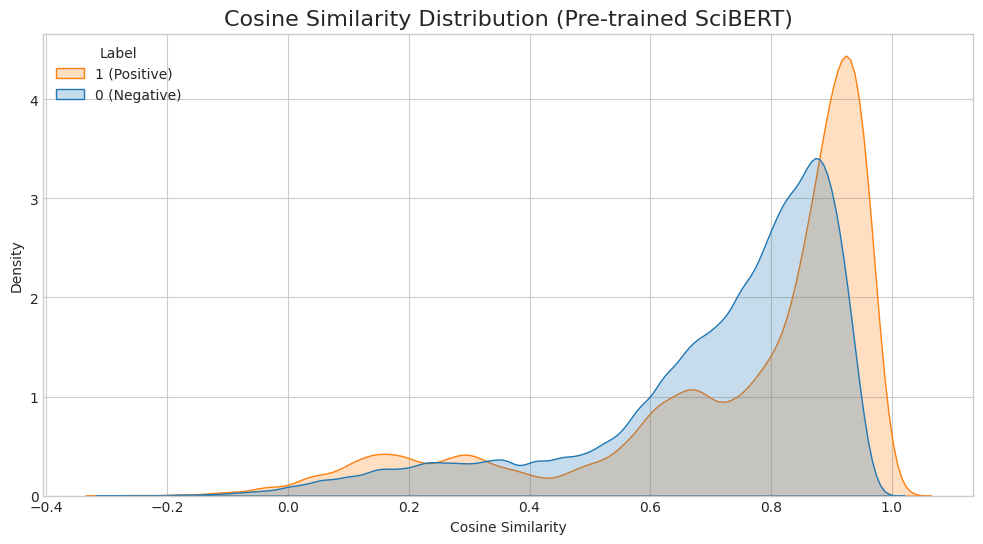


--- Statistics ---
Positive Pairs (label=1):


count    7013.000000
mean        0.737488
std         0.253758
min        -0.270415
25%         0.642839
50%         0.848006
75%         0.918669
max         1.000000
Name: cosine_similarity, dtype: float64


Negative Pairs (label=0):


count    27611.000000
mean         0.706365
std          0.215047
min         -0.276888
25%          0.627924
50%          0.774437
75%          0.861129
max          0.979200
Name: cosine_similarity, dtype: float64

In [7]:
# --- 7. 可視化1: 正例と負例の分布の比較 ---
print("\n--- Visualization 1: Positive vs. Negative Distribution ---")

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid')

# hue='label' を使うことで、ラベル(0/1)ごとに色分けされたKDEプロット（カーネル密度推定）を描画
sns.kdeplot(
    data=df_results, 
    x='cosine_similarity', 
    hue='label', 
    fill=True, 
    common_norm=False, # 0と1のカウント数が違っても面積が同じにならないようにする
    bw_adjust=0.5
)

plt.title('Cosine Similarity Distribution (Pre-trained SciBERT)', fontsize=16)
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend(title='Label', labels=['1 (Positive)', '0 (Negative)'])
plt.show()

print("\n--- Statistics ---")
print("Positive Pairs (label=1):")
display(df_results[df_results['label']==1]['cosine_similarity'].describe())
print("\nNegative Pairs (label=0):")
display(df_results[df_results['label']==0]['cosine_similarity'].describe())


--- Visualization 2: Positive Pair Outlier Check ---


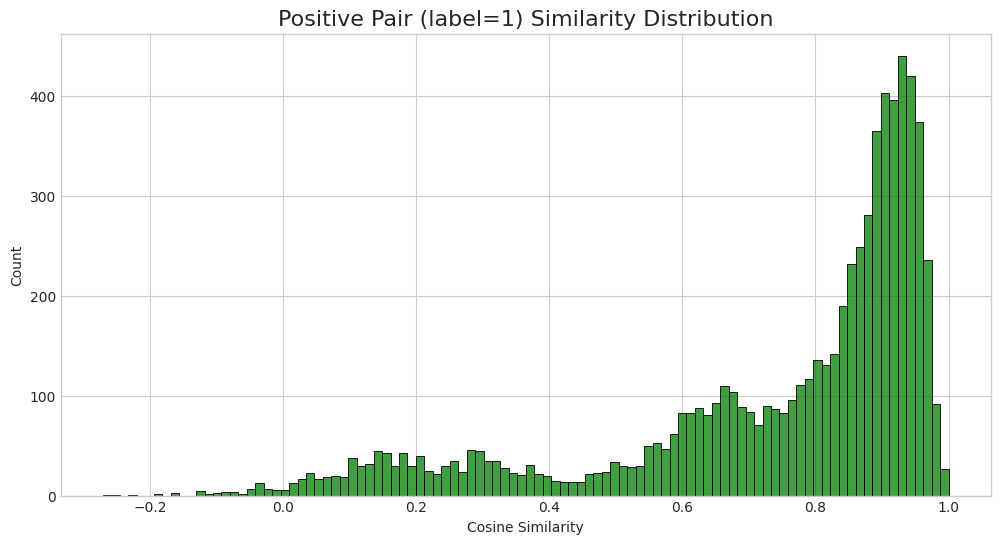


Number of 'Positive' pairs with similarity < 0.5: 1,111 / 7,013


In [8]:
# --- 8. 可視化2: 正例ペアの分布（外れ値の確認）---
print("\n--- Visualization 2: Positive Pair Outlier Check ---")

plt.figure(figsize=(12, 6))

# 正例(label=1)のみをヒストグラムで表示
sns.histplot(
    df_results[df_results['label']==1], 
    x='cosine_similarity', 
    bins=100,
    color='green'
)

plt.title('Positive Pair (label=1) Similarity Distribution', fontsize=16)
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.show()

# （例）コサイン類似度が 0.5 未満の正例ペアを「外れ値」としてカウント
outliers = df_results[(df_results['label']==1) & (df_results['cosine_similarity'] < 0.5)]
print(f"\nNumber of 'Positive' pairs with similarity < 0.5: {len(outliers):,} / {len(df_results[df_results['label']==1]):,}")


--- Visualization 3: Box Plot of Similarity Distribution ---


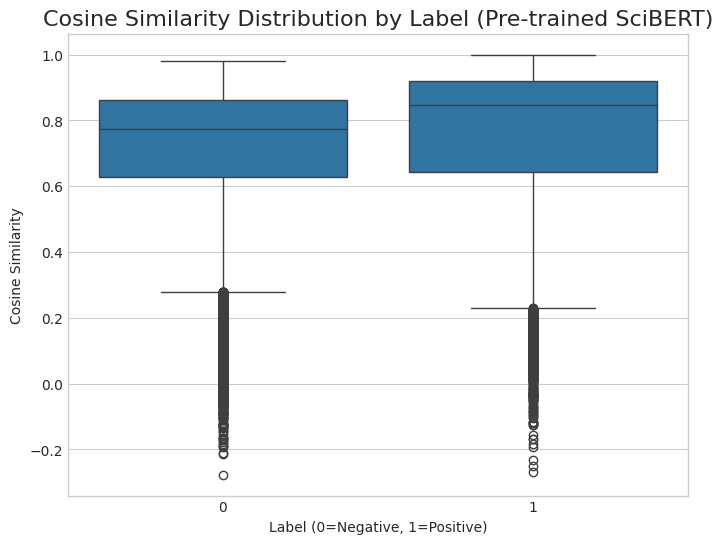

In [9]:
# --- 9. 可視化3: Box Plotによる統計的比較 ---
print("\n--- Visualization 3: Box Plot of Similarity Distribution ---")

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df_results, # セル 6 で作成したDataFrame
    x='label',
    y='cosine_similarity'
)
plt.title('Cosine Similarity Distribution by Label (Pre-trained SciBERT)', fontsize=16)
plt.xlabel('Label (0=Negative, 1=Positive)')
plt.ylabel('Cosine Similarity')
plt.show()


--- Visualization 4: t-SNE Scatter Plot of Difference Vectors ---
Sampling 5000 pairs for t-SNE...
Standardizing vectors...
Running t-SNE (this may take a few minutes)...
Plotting t-SNE results...


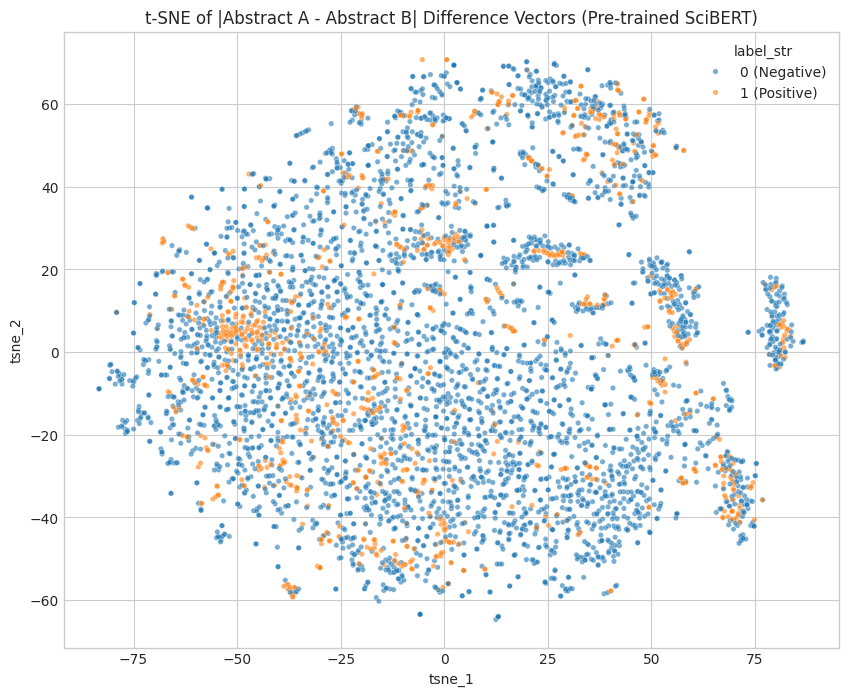

In [10]:
# --- 10. 可視化4: t-SNE散布図（差分ベクトル） ---
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

print("\n--- Visualization 4: t-SNE Scatter Plot of Difference Vectors ---")
N_SAMPLES = 5000 # サンプリング数

# 1. 差分ベクトルを計算 (セル 6 で計算したテンソルを使用)
try:
    diff_vectors = torch.abs(vecs_a_tensor - vecs_b_tensor).numpy()
    labels = df_results['label'].to_numpy() # 対応するラベル
except NameError:
    print("❌ Error: 'vecs_a_tensor' or 'vecs_b_tensor' not found. Please re-run Cell 6.")
    raise

# 2. 5000件にサンプリング (ラベル比率を維持)
print(f"Sampling {N_SAMPLES} pairs for t-SNE...")
vectors_sampled, labels_sampled = resample(
    diff_vectors,
    labels,
    n_samples=N_SAMPLES,
    random_state=42,
    stratify=labels
)

# 3. 標準化
print("Standardizing vectors...")
scaler = StandardScaler()
vectors_scaled = scaler.fit_transform(vectors_sampled)

# 4. t-SNEで2次元に削減
print("Running t-SNE (this may take a few minutes)...")
# ▼▼▼ 修正点: 'n_iter' を 'max_iter' に変更 ▼▼▼
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
vectors_2d = tsne.fit_transform(vectors_scaled)

# 5. プロット
print("Plotting t-SNE results...")
df_tsne = pd.DataFrame({
    'tsne_1': vectors_2d[:, 0],
    'tsne_2': vectors_2d[:, 1],
    'label': labels_sampled
})
df_tsne['label_str'] = df_tsne['label'].map({0: '0 (Negative)', 1: '1 (Positive)'})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_tsne,
    x='tsne_1',
    y='tsne_2',
    hue='label_str',
    alpha=0.6,
    s=15
)
plt.title('t-SNE of |Abstract A - Abstract B| Difference Vectors (Pre-trained SciBERT)')
plt.show()


--- Visualization 4b: UMAP Scatter Plot of Difference Vectors ---
Using existing sampled and scaled vectors from t-SNE cell.
Running UMAP (this is usually faster than t-SNE)...


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Plotting UMAP results...


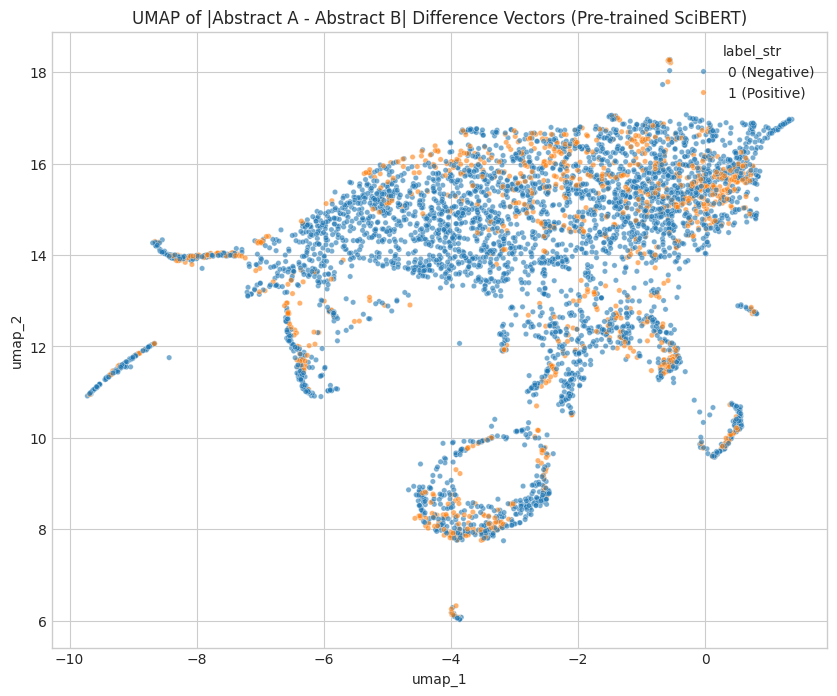

In [11]:
# --- 10b. 可視化4b: UMAP散布図（差分ベクトル） ---
import umap # UMAPライブラリをインポート
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

print("\n--- Visualization 4b: UMAP Scatter Plot of Difference Vectors ---")
N_SAMPLES = 5000 # サンプリング数

# 1. 差分ベクトルとラベルを（セル6またはセル10から）取得
try:
    if 'vectors_sampled' not in locals() or 'labels_sampled' not in locals():
        print(f"Sampling {N_SAMPLES} pairs for UMAP...")
        diff_vectors = torch.abs(vecs_a_tensor - vecs_b_tensor).numpy()
        labels = df_results['label'].to_numpy()
        vectors_sampled, labels_sampled = resample(
            diff_vectors,
            labels,
            n_samples=N_SAMPLES,
            random_state=42,
            stratify=labels
        )
        print("Standardizing vectors...")
        scaler = StandardScaler()
        vectors_scaled = scaler.fit_transform(vectors_sampled)
    else:
        print("Using existing sampled and scaled vectors from t-SNE cell.")
        
except NameError:
    print("❌ Error: 'vecs_a_tensor' or 'df_results' not found. Please re-run Cell 6.")
    raise

# 4. UMAPで2次元に削減
print("Running UMAP (this is usually faster than t-SNE)...")
# ▼▼▼ 修正点: TSNE -> umap.UMAP ▼▼▼
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
vectors_2d_umap = reducer.fit_transform(vectors_scaled)

# 5. プロット
print("Plotting UMAP results...")
df_umap = pd.DataFrame({
    'umap_1': vectors_2d_umap[:, 0],
    'umap_2': vectors_2d_umap[:, 1],
    'label': labels_sampled
})
df_umap['label_str'] = df_umap['label'].map({0: '0 (Negative)', 1: '1 (Positive)'})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_umap,
    x='umap_1',
    y='umap_2',
    hue='label_str',
    alpha=0.6,
    s=15
)
plt.title('UMAP of |Abstract A - Abstract B| Difference Vectors (Pre-trained SciBERT)')
plt.show()


--- Visualization 5: Token Length Difference vs. Similarity ---
Calculating token lengths for correlation plot (this may take a moment)...


Map:   0%|          | 0/34624 [00:00<?, ? examples/s]

Plotting scatter plot for Token Length Difference vs. Similarity...


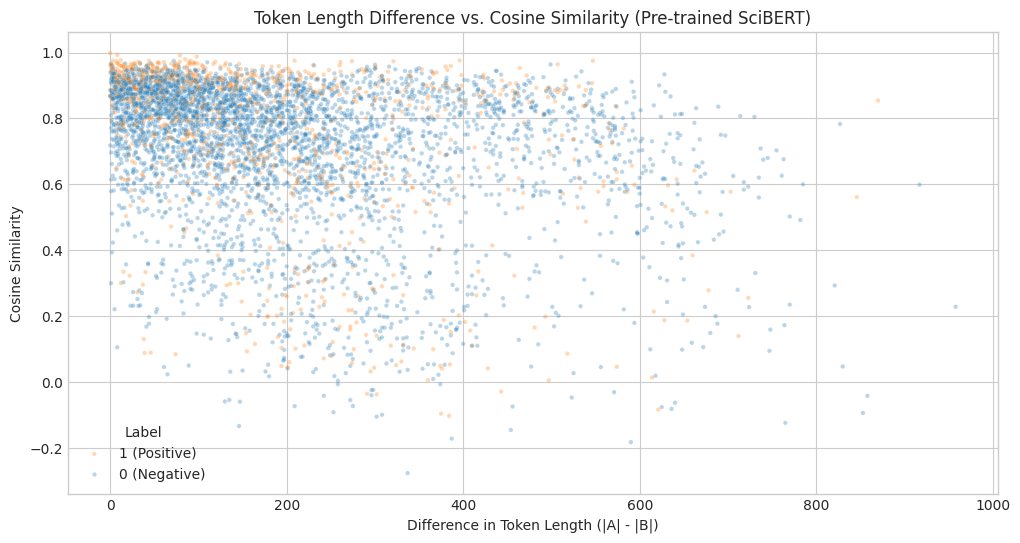

In [12]:
# --- 11. 可視化5: トークン長（差分） vs 類似度 ---
print("\n--- Visualization 5: Token Length Difference vs. Similarity ---")

# df_results: 'cosine_similarity' と 'label' が入っている
# dataset: 'abstract_a' と 'abstract_b' が入っている
# (両方のインデックスは一致している前提)
df_corr = df_results.copy()

print("Calculating token lengths for correlation plot (this may take a moment)...")

# トークン長を計算する関数 (batched)
def get_lengths(batch):
    # tokenizerはセル 5で定義済み
    lengths_a = [len(tokenizer(t, truncation=False)['input_ids']) for t in batch['abstract_a']]
    lengths_b = [len(tokenizer(t, truncation=False)['input_ids']) for t in batch['abstract_b']]
    return {
        'token_length_a': lengths_a,
        'token_length_b': lengths_b,
    }

# dataset.map を使って効率的に計算
length_data = dataset.map(get_lengths, batched=True, batch_size=512)

df_corr['token_length_a'] = length_data['token_length_a']
df_corr['token_length_b'] = length_data['token_length_b']
df_corr['token_length_diff'] = (df_corr['token_length_a'] - df_corr['token_length_b']).abs()

print("Plotting scatter plot for Token Length Difference vs. Similarity...")
plt.figure(figsize=(12, 6))
# 5000件をランダムサンプリングしてプロット
sns.scatterplot(
    data=df_corr.sample(min(5000, len(df_corr))), 
    x='token_length_diff',
    y='cosine_similarity',
    hue='label',
    alpha=0.3,
    s=10 
)
plt.title('Token Length Difference vs. Cosine Similarity (Pre-trained SciBERT)')
plt.xlabel('Difference in Token Length (|A| - |B|)')
plt.ylabel('Cosine Similarity')
plt.legend(title='Label', labels=['1 (Positive)', '0 (Negative)'])
plt.show()